In [1]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [8]:
# Training dataset file to use. String expected
# training_file = "datasets/ncombined_train.csv"
# training_file = "datasets/special_train.csv"
# training_file = "datasets/unique_normal_train.csv"
# training_file = "datasets/unique_normal_random.csv"
training_file = "../datasets/training/unor.csv"


# testing_file = "datasets/unique_normal_test.csv"
# testing_file = "datasets/ncombined_test.csv"
# testing_file = "datasets/special.csv"
testing_file = "../datasets/testing/attack.csv"
# testing_file = "datasets/unconstrained.csv"





In [9]:
training_data = pd.read_csv(training_file)
training_data.head()

,CB_0_closed,CB_1_closed,CB_2_closed,CB_3_closed,CB_4_closed,CB_5_closed,CB_6_closed,CB_7_closed,CB_8_closed,CB_9_closed,...,trafo_1_in_service,trafo_2_in_service,trafo_3_in_service,trafo_4_in_service,trafo_5_in_service,feeder_0_in_service,feeder_1_in_service,total_init_load,anomaly,reason
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,8.366852,0,No anomaly
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,8.366852,0,No anomaly
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,26.670039,0,No anomaly
3,1,1,1,1,1,1,1,0,1,1,...,1,1,0,1,1,1,1,26.670039,0,No anomaly
4,1,1,1,1,1,1,1,0,1,1,...,1,1,0,1,1,0,1,26.670039,0,No anomaly


In [10]:
testing_data = pd.read_csv(testing_file)
testing_data.head()

,CB_0_closed,CB_1_closed,CB_2_closed,CB_3_closed,CB_4_closed,CB_5_closed,CB_6_closed,CB_7_closed,CB_8_closed,CB_9_closed,...,trafo_1_in_service,trafo_2_in_service,trafo_3_in_service,trafo_4_in_service,trafo_5_in_service,feeder_0_in_service,feeder_1_in_service,total_init_load,anomaly,reason
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,18.3,0,No anomaly
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,18.3,0,No anomaly
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,18.3,0,No anomaly
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,1,1,18.3,0,No anomaly
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,0,1,1,14.1,1,Config Violation: Trafo3


In [11]:
neg, pos = np.bincount(training_data['anomaly'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 45681
    Positive: 17184 (37.62% of total)



In [12]:
neg, pos = np.bincount(testing_data['anomaly'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 262144
    Positive: 258048 (98.44% of total)



In [14]:
# Use a utility from sklearn to split and shuffle your dataset.
# train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(training_data, test_size=0.2)
train_df.pop('reason')
val_df.pop('reason')
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('anomaly'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('anomaly'))
# test_labels = np.array(test_df.pop('anomaly'))

train_features = np.array(train_df)
val_features = np.array(val_df)
# test_features = np.array(test_df)

# training_data = pd.read_csv(training_file).to_numpy()
# training_X = training_data[:,:-1]
# training_y = training_data[:,-1].astype(np.int64)


In [15]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [16]:
#Function to vary number of nodes
def FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes):
    layers = []
    
    nodes_increment = (last_layer_nodes - first_layer_nodes)/ (n_layers-1)
    
    nodes = first_layer_nodes
    for i in range(1, n_layers+1):
        layers.append(math.ceil(nodes))
        nodes = nodes + nodes_increment
    
    return layers

In [17]:
#Dynamically change model parameters
modelNumber = 0
def createmodel(n_layers, first_layer_nodes, last_layer_nodes, activation_func, loss_func, output_bias=None):
    global modelNumber
    print("Model :" + str(modelNumber))
    print("n_layers: {}, first_layer_nodes: {}, last_layer_nodes: {}, activation_func: {}, loss_func: {}".format(n_layers, first_layer_nodes, last_layer_nodes, activation_func, loss_func))
    model = Sequential()
    n_nodes = FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes)
    for i in range(1, n_layers):
        if i==1:
            model.add(Dense(first_layer_nodes, input_dim=X_train.shape[1], activation=activation_func))
        else:
            model.add(Dense(n_nodes[i-1], activation=activation_func))
            
    #Finally, the output layer should have a single node in binary classification
    model.add(Dense(1, activation="sigmoid", bias_initializer=output_bias)) #Change to relu to get probability
    model.compile(optimizer='adam', loss=loss_func, metrics = METRICS) #note: metrics could also be 'mse'
    modelNumber += 1
    return model

##Wrap model into scikit-learn
model =  KerasClassifier(build_fn=createmodel, verbose = 1) 

c:\Users\Jiawe\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


In [14]:
activation_funcs = ['sigmoid', 'relu', 'tanh'] 
loss_funcs = ['binary_crossentropy','hinge']
param_grid = dict(n_layers=[2,4,6,8,10], first_layer_nodes = [256,128,64,32,16], last_layer_nodes = [4],  activation_func = activation_funcs, loss_func = loss_funcs, batch_size = [100], epochs = [100])
grid = GridSearchCV(estimator = model, param_grid = param_grid)

In [18]:
X_train = train_features
y_train = train_labels
# grid.fit(X_train,y_train)

In [ ]:
print(grid.best_score_)
print(grid.best_params_)

In [ ]:
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']].to_csv('GridOptimization_special.csv')

In [19]:
#Build the best modelgrid.best_params_
# best_params = grid.best_params_

# best_params = {"n_layers":2, "first_layer_nodes":256, "last_layer_nodes":4, "activation_func":"sigmoid" ,"loss_func":"binary_crossentropy", "epochs": 100, "batch_size": 100} #Special
best_params = {"n_layers":4, "first_layer_nodes":256, "last_layer_nodes":4, "activation_func":"relu" ,"loss_func":"binary_crossentropy", "epochs": 100, "batch_size": 100} #Unique_Normal_Options_Random

# best_params = {"n_layers":4, "first_layer_nodes":256, "last_layer_nodes":4, "activation_func":"tanh" ,"loss_func":"binary_crossentropy", "epochs": 100, "batch_size": 100} #Unique_Normal/NCombined

# best_params = {"n_layers": 4, "first_layer_nodes": 256, "last_layer_nodes": 4, "activation_func": "sigmoid", "loss_func": "binary_crossentropy", 'epochs': 100, 'batch_size': 100} #Constrained

n_layers = best_params["n_layers"]
first_layer_nodes = best_params["first_layer_nodes"]
last_layer_nodes = best_params["last_layer_nodes"]
activation_func = best_params["activation_func"]
loss_func = best_params["loss_func"]
epoch_count = best_params["epochs"]

model = createmodel(n_layers, first_layer_nodes, last_layer_nodes, activation_func, loss_func)
model.summary()
baseline = model.fit(X_train, y_train, epochs=epoch_count, validation_data=(val_features, val_labels), verbose=0)


Model :0
n_layers: 4, first_layer_nodes: 256, last_layer_nodes: 4, activation_func: relu, loss_func: binary_crossentropy
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               20480     
                                                                 
 dense_1 (Dense)             (None, 172)               44204     
                                                                 
 dense_2 (Dense)             (None, 88)                15224     
                                                                 
 dense_3 (Dense)             (None, 1)                 89        
                                                                 
Total params: 79,997
Trainable params: 79,997
Non-trainable params: 0
_________________________________________________________________


c:\Users\Jiawe\Anaconda3\envs\gpu\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


In [20]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
                   color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
                   color=colors[n], label='Val ' + label,
                   linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

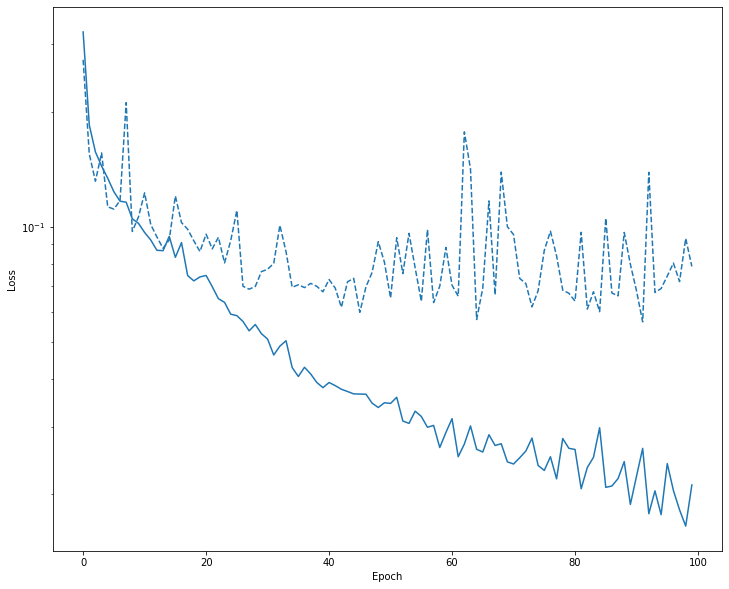

In [21]:
plot_loss(baseline, "Baseline", 0)

In [23]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend();

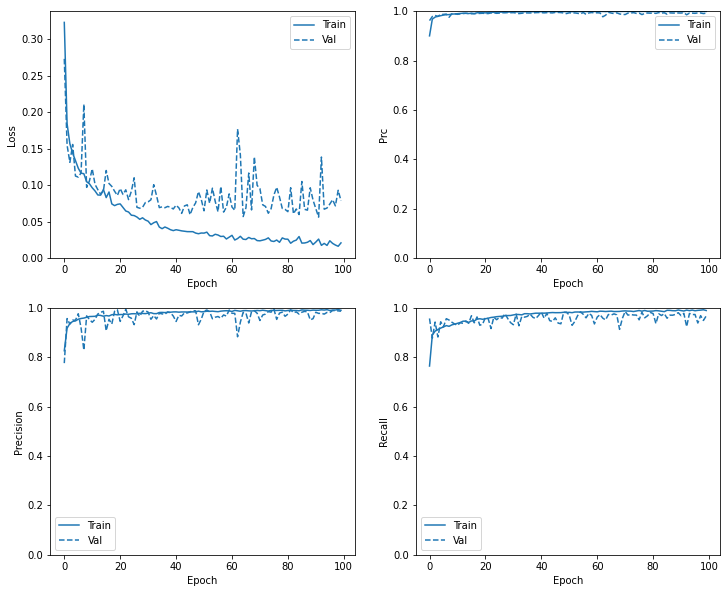

In [24]:
plot_metrics(baseline)

In [26]:
# testing_special_file = "./datasets/testing_data_special2.csv"
# testing_special_file = "./datasets/unique_normal_test.csv"
# testing_special_file = "./datasets/NCombined_test.csv"
# testing_special_file = "./datasets/special_test.csv"
# testing_special_file = "./datasets/unconstrained.csv"
testing_special_file = "../datasets/testing/attack.csv"
# testing_special_file = "./datasets/special.csv"


# testing_data = pd.read_csv(testing_file)
testing_data = pd.read_csv(testing_special_file)

testing_data.describe()

,CB_0_closed,CB_1_closed,CB_2_closed,CB_3_closed,CB_4_closed,CB_5_closed,CB_6_closed,CB_7_closed,CB_8_closed,CB_9_closed,...,trafo_0_in_service,trafo_1_in_service,trafo_2_in_service,trafo_3_in_service,trafo_4_in_service,trafo_5_in_service,feeder_0_in_service,feeder_1_in_service,total_init_load,anomaly
count,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.0,262144.0,262144.0,...,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.0,262144.0,262144.000000,262144.000000
mean,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.0,1.0,1.0,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.0,1.0,5.921919,0.984375
std,0.500001,0.500001,0.500001,0.500001,0.500001,0.500001,0.500001,0.0,0.0,0.0,...,0.500001,0.500001,0.500001,0.500001,0.500001,0.500001,0.0,0.0,5.515480,0.124020
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,1.000000
50%,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.0,1.0,1.0,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.0,1.0,6.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,10.200000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,18.300000,1.000000


In [27]:
neg, pos = np.bincount(testing_data['anomaly'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 262144
    Positive: 258048 (98.44% of total)



In [28]:
test_df = testing_data
test_df.pop('reason')
test_labels = np.array(test_df.pop('anomaly'))
test_features = np.array(test_df)

# test_features = scaler.transform(test_features)
# test_features = np.clip(test_features, -5, 5)

print('Test labels shape:', test_labels.shape)
print('Test features shape:', test_features.shape)


Test labels shape: (262144,)
Test features shape: (262144, 79)


In [44]:
train_predictions_baseline = model.predict(train_features)
test_predictions_baseline = model.predict(test_features)

In [45]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Commands Detected (True Negatives): ', cm[0][0])
    print('Legitimate Commands Incorrectly Detected (False Positives): ', cm[0][1])
    print('Malicious Commands Missed (False Negatives): ', cm[1][0])
    print('Malicious Commands Detected (True Positives): ', cm[1][1])
    print('Total Malicious Commands: ', np.sum(cm[1]))

True Negatives: 4096
True Positives: 258048
Legitimate Commands Detected (True Negatives):  4095
Legitimate Commands Incorrectly Detected (False Positives):  1
Malicious Commands Missed (False Negatives):  7443
Malicious Commands Detected (True Positives):  250605
Total Malicious Commands:  258048


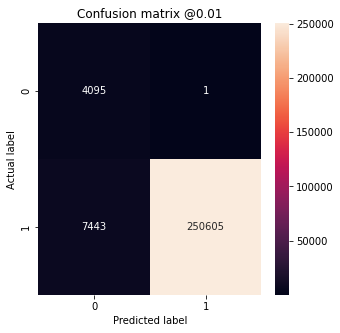

In [46]:
print("True Negatives: " + str(neg))
print("True Positives: " + str(pos))
# print("Predicted Negatives: " + str(nn))
# print("Predicted Positives: " + str(pp))

plot_cm(test_labels, test_predictions_baseline, 0.012)

loss :  0.3251256238232548
tp :  247728.0
fp :  0.0
tn :  4096.0
fn :  10320.0
accuracy :  0.9606323
precision :  1.0
recall :  0.9600074
auc :  0.9869069
prc :  0.9997925

Legitimate Commands Detected (True Negatives):  4095
Legitimate Commands Incorrectly Detected (False Positives):  1
Malicious Commands Missed (False Negatives):  7443
Malicious Commands Detected (True Positives):  250605
Total Malicious Commands:  258048


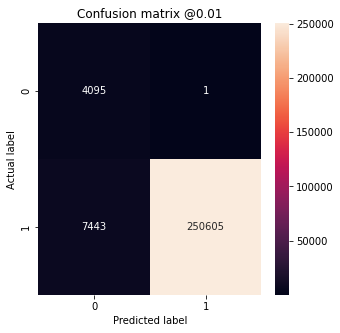

In [47]:
BATCH_SIZE = 1024
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()
plot_cm(test_labels, test_predictions_baseline, 0.012)

In [48]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

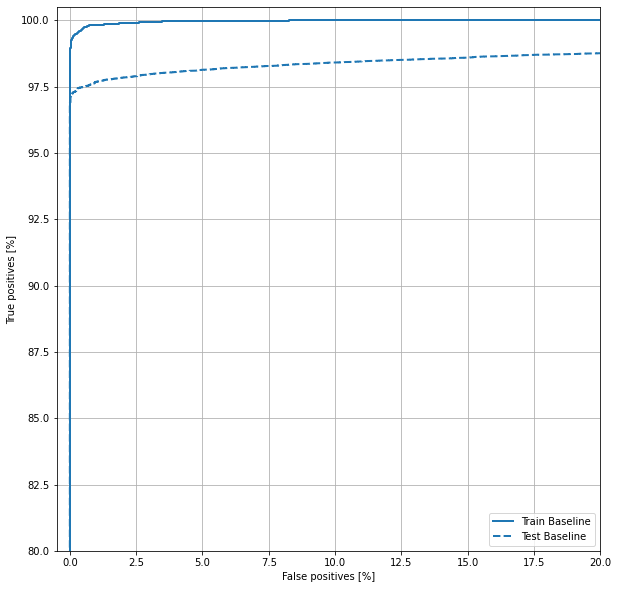

In [49]:
#ROC: This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [50]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

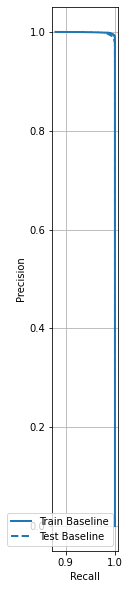

In [51]:
#  AUPRC. Area under the interpolated precision-recall curve, obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.

plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [52]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0107


In [53]:
initial_bias = np.log([neg/pos])
initial_bias

array([-4.14313473])

In [54]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = createmodel(n_layers, first_layer_nodes, last_layer_nodes, activation_func, loss_func, output_bias)


  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  return model

In [55]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

Model :1
n_layers: 4, first_layer_nodes: 256, last_layer_nodes: 4, activation_func: relu, loss_func: binary_crossentropy


c:\Users\Jiawe\Anaconda3\envs\gpu\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


array([[7.41511583e-04],
       [1.74644589e-03],
       [1.35272741e-04],
       [2.60889530e-04],
       [1.04897284e-04],
       [1.94907188e-03],
       [2.60308385e-03],
       [6.98506832e-03],
       [2.51561403e-04],
       [9.70491019e-05]], dtype=float32)

In [56]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

c:\Users\Jiawe\Anaconda3\envs\gpu\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Loss: 2.7805


In [57]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [58]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(val_features, val_labels), 
    verbose=0)

Model :2
n_layers: 4, first_layer_nodes: 256, last_layer_nodes: 4, activation_func: relu, loss_func: binary_crossentropy


In [59]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(val_features, val_labels), 
    verbose=0)

Model :3
n_layers: 4, first_layer_nodes: 256, last_layer_nodes: 4, activation_func: relu, loss_func: binary_crossentropy


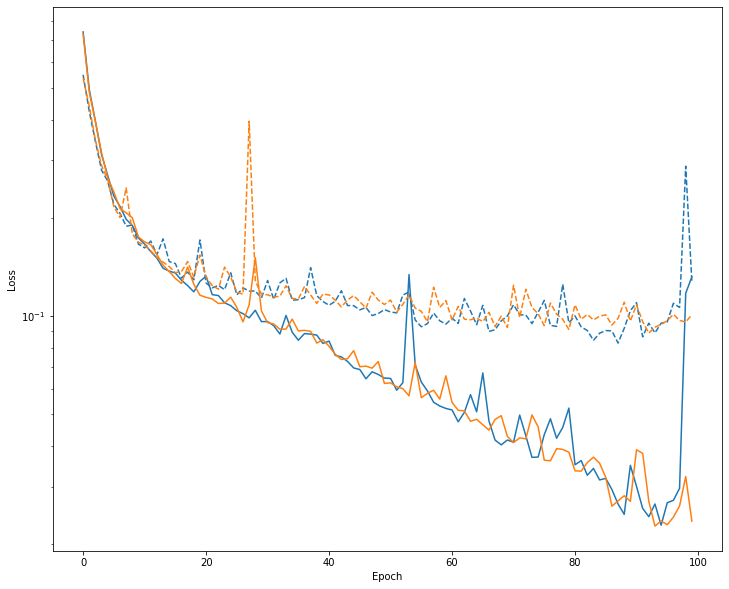

In [60]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [61]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [62]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Model :4
n_layers: 4, first_layer_nodes: 256, last_layer_nodes: 4, activation_func: relu, loss_func: binary_crossentropy
Train on 36544 samples, validate on 9137 samples
Epoch 1/100
36544/36544 [==============================] - 1s 21us/sample - loss: 0.8761 - tp: 5112.0000 - fp: 4190.0000 - tn: 18594.0000 - fn: 8648.0000 - accuracy: 0.6487 - precision: 0.5496 - recall: 0.3715 - auc: 0.6146 - prc: 0.4942 - val_loss: 0.5989 - val_tp: 990.0000 - val_fp: 637.0000 - val_tn: 5076.0000 - val_fn: 2434.0000 - val_accuracy: 0.6639 - val_precision: 0.6085 - val_recall: 0.2891 - val_auc: 0.7166 - val_prc: 0.5933
Epoch 2/100
36544/36544 [==============================] - 0s 7us/sample - loss: 0.5677 - tp: 5825.0000 - fp: 3166.0000 - tn: 19618.0000 - fn: 7935.0000 - accuracy: 0.6962 - precision: 0.6479 - recall: 0.4233 - auc: 0.7614 - prc: 0.6452 - val_loss: 0.5294 - val_tp: 1449.0000 - val_fp: 661.0000 - val_tn: 5052.0000 - val_fn: 1975.0000 - val_accuracy: 0.7115 - val_precision: 0.6867 - val_rec

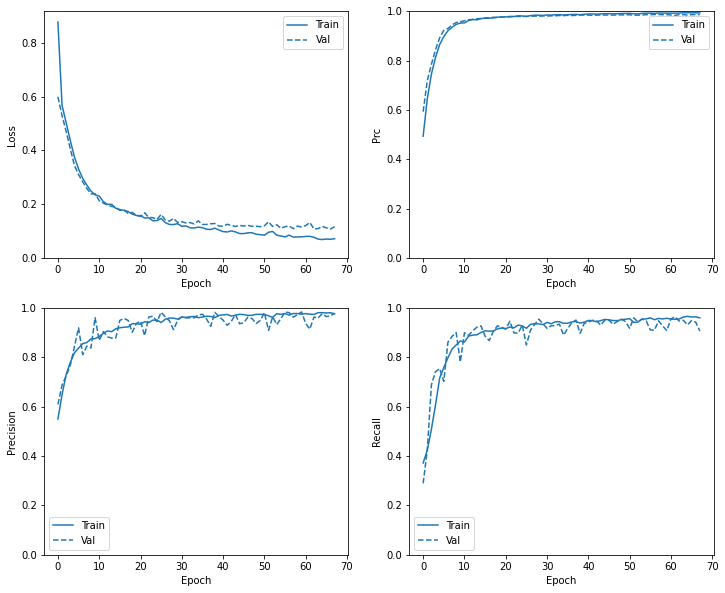

In [63]:
plot_metrics(baseline_history)

In [64]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.25428363625827743
tp :  237330.0
fp :  0.0
tn :  4096.0
fn :  20718.0
accuracy :  0.9209671
precision :  1.0
recall :  0.9197126
auc :  0.98745
prc :  0.9998003

Legitimate Commands Detected (True Negatives):  4096
Legitimate Commands Incorrectly Detected (False Positives):  0
Malicious Commands Missed (False Negatives):  20718
Malicious Commands Detected (True Positives):  237330
Total Malicious Commands:  258048


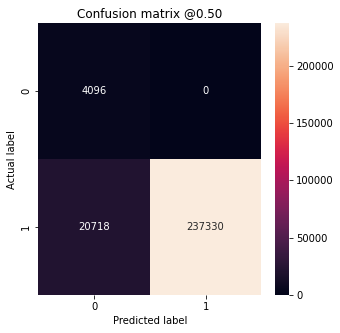

In [65]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [250]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 32.00
Weight for class 1: 0.51


In [251]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Model :6
n_layers: 4, first_layer_nodes: 256, last_layer_nodes: 4, activation_func: relu, loss_func: binary_crossentropy
Train on 36544 samples, validate on 9137 samples
Epoch 1/100
34816/36544 [===========================>..] - ETA: 0s - loss: 1.1233 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 21689.0000 - fn: 13127.0000 - accuracy: 0.6230 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5644 - prc: 0.4505

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


36544/36544 [==============================] - 1s 37us/sample - loss: 1.1165 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 22787.0000 - fn: 13757.0000 - accuracy: 0.6235 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5723 - prc: 0.4565 - val_loss: 1.5229 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5710.0000 - val_fn: 3427.0000 - val_accuracy: 0.6249 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7432 - val_prc: 0.6348
Epoch 2/100
36544/36544 [==============================] - 0s 8us/sample - loss: 0.9630 - tp: 66.0000 - fp: 0.0000e+00 - tn: 22787.0000 - fn: 13691.0000 - accuracy: 0.6254 - precision: 1.0000 - recall: 0.0048 - auc: 0.7786 - prc: 0.6805 - val_loss: 1.4976 - val_tp: 41.0000 - val_fp: 0.0000e+00 - val_tn: 5710.0000 - val_fn: 3386.0000 - val_accuracy: 0.6294 - val_precision: 1.0000 - val_recall: 0.0120 - val_auc: 0.8373 - val_prc: 0.7520
Epoch 3/100
36544/36544 [==============================] - 0s 8us/sample - loss: 0.8543 - tp: 657.0000 - fp: 0.

In [252]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


loss :  1.7153811616899475
tp :  169541.0
fp :  0.0
tn :  4096.0
fn :  88507.0
accuracy :  0.6623726
precision :  1.0
recall :  0.6570134
auc :  0.925541
prc :  0.99876803

Legitimate Commands Detected (True Negatives):  4088
Legitimate Commands Incorrectly Detected (False Positives):  8
Malicious Commands Missed (False Negatives):  8810
Malicious Commands Detected (True Positives):  249238
Total Malicious Commands:  258048


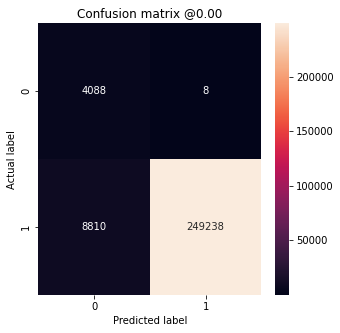

In [257]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted, 0.0001)

In [258]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]


In [259]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(22787, 79)

In [260]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(45574, 79)

In [261]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [262]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

RuntimeError: `tf.data.Dataset` only supports Python-style iteration in eager mode or within tf.function.

In [263]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [264]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

RuntimeError: `tf.data.Dataset` only supports Python-style iteration in eager mode or within tf.function.

In [266]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

4.0

In [267]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Model :8
n_layers: 4, first_layer_nodes: 256, last_layer_nodes: 4, activation_func: relu, loss_func: binary_crossentropy
Train on 4.0 steps, validate on 5 steps
Epoch 1/100
4/4 [==============================] - ETA: 0s - batch: 1.5000 - size: 1.0000 - loss: 1.3500 - tp: 1183.0000 - fp: 535.0000 - tn: 3535.0000 - fn: 2939.0000 - accuracy: 0.5759 - precision: 0.6886 - recall: 0.2870 - auc: 0.5746 - prc: 0.5997               

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


4/4 [==============================] - 2s 507ms/step - batch: 1.5000 - size: 1.0000 - loss: 1.3500 - tp: 1183.0000 - fp: 535.0000 - tn: 3535.0000 - fn: 2939.0000 - accuracy: 0.5759 - precision: 0.6886 - recall: 0.2870 - auc: 0.5746 - prc: 0.5997 - val_loss: 1.0661 - val_tp: 2267.0000 - val_fp: 2085.0000 - val_tn: 3625.0000 - val_fn: 1160.0000 - val_accuracy: 0.6449 - val_precision: 0.5209 - val_recall: 0.6615 - val_auc: 0.6649 - val_prc: 0.5204
Epoch 2/100
4/4 [==============================] - 0s 50ms/step - batch: 1.5000 - size: 1.0000 - loss: 0.8880 - tp: 2756.0000 - fp: 1388.0000 - tn: 2650.0000 - fn: 1398.0000 - accuracy: 0.6599 - precision: 0.6651 - recall: 0.6635 - auc: 0.6741 - prc: 0.6591 - val_loss: 0.7462 - val_tp: 2197.0000 - val_fp: 1886.0000 - val_tn: 3824.0000 - val_fn: 1230.0000 - val_accuracy: 0.6590 - val_precision: 0.5381 - val_recall: 0.6411 - val_auc: 0.6810 - val_prc: 0.5429
Epoch 3/100
4/4 [==============================] - 0s 48ms/step - batch: 1.5000 - size: 1.

In [269]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Model :10
n_layers: 4, first_layer_nodes: 256, last_layer_nodes: 4, activation_func: relu, loss_func: binary_crossentropy
Train on 20 steps, validate on 5 steps
Epoch 1/1000
20/20 [==============================] - 3s 115ms/step - batch: 9.5000 - size: 1.0000 - loss: 0.8722 - tp: 10707.0000 - fp: 4968.0000 - tn: 15536.0000 - fn: 9749.0000 - accuracy: 0.6407 - precision: 0.6831 - recall: 0.5234 - auc: 0.6506 - prc: 0.6425 - val_loss: 0.6442 - val_tp: 2209.0000 - val_fp: 1801.0000 - val_tn: 3909.0000 - val_fn: 1218.0000 - val_accuracy: 0.6696 - val_precision: 0.5509 - val_recall: 0.6446 - val_auc: 0.6792 - val_prc: 0.5760
Epoch 2/1000
20/20 [==============================] - 1s 30ms/step - batch: 9.5000 - size: 1.0000 - loss: 0.6001 - tp: 12803.0000 - fp: 4793.0000 - tn: 15865.0000 - fn: 7499.0000 - accuracy: 0.6999 - precision: 0.7276 - recall: 0.6306 - auc: 0.7446 - prc: 0.7433 - val_loss: 0.5445 - val_tp: 2159.0000 - val_fp: 1038.0000 - val_tn: 4672.0000 - val_fn: 1268.0000 - val_accu

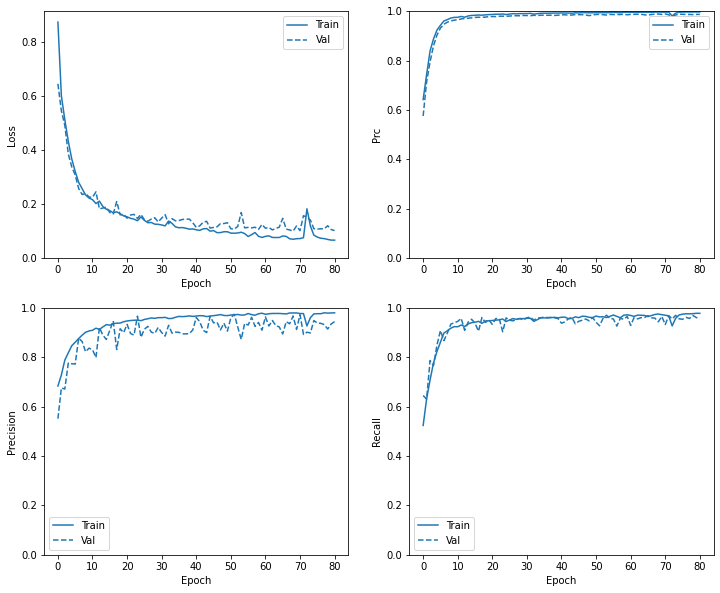

In [270]:
plot_metrics(resampled_history)

In [271]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


loss :  0.21909237801655473
tp :  241754.0
fp :  0.0
tn :  4096.0
fn :  16294.0
accuracy :  0.9378433
precision :  1.0
recall :  0.9368567
auc :  0.98902947
prc :  0.99982595

Legitimate Commands Detected (True Negatives):  869
Legitimate Commands Incorrectly Detected (False Positives):  3227
Malicious Commands Missed (False Negatives):  742
Malicious Commands Detected (True Positives):  257306
Total Malicious Commands:  258048


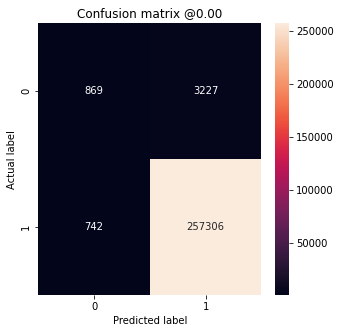

In [278]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)